#### Библиотеки

In [11]:
import os
import datetime
import json
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#### Обработка данных

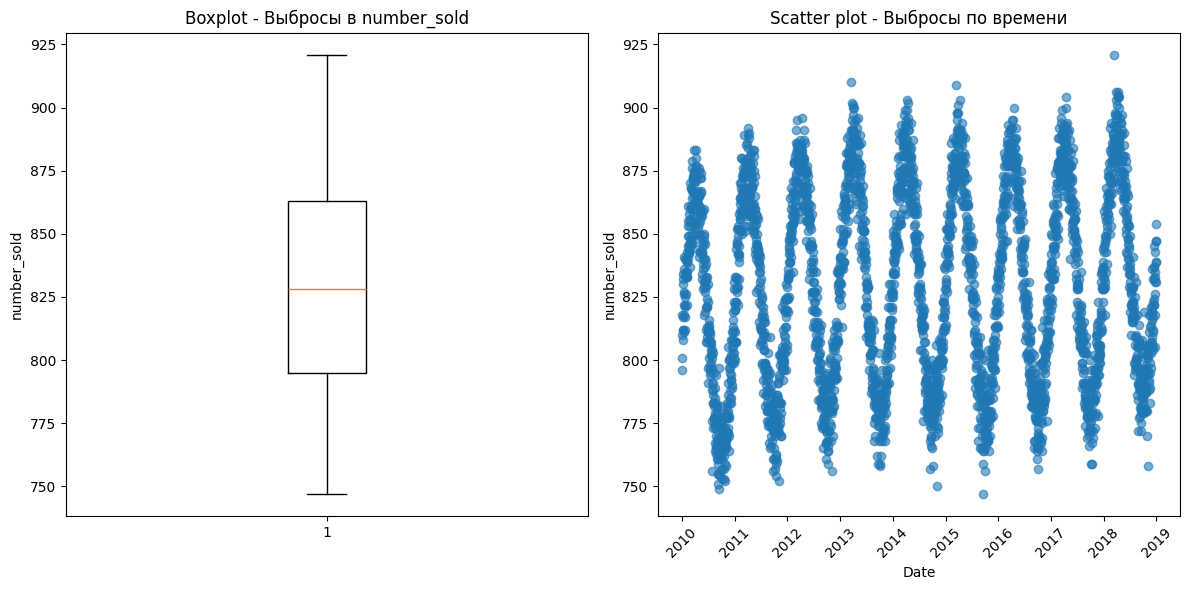

In [1]:
def load_data(file_path):
    return pd.read_csv(file_path)

def clean_and_preprocess_data(df):
    df_clean = df.copy()
    df_clean = convert_time_format(df_clean)
    df_clean = remove_duplicates(df_clean)
    df_clean = check_time_monotonicity(df_clean)
    df_clean = handle_missing_values(df_clean)
    detect_outliers_visual(df_clean)
    df_clean = handle_outliers(df_clean)
    df_clean = resample_data(df_clean)
    return df_clean

def convert_time_format(df):
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def remove_duplicates(df):
    return df.drop_duplicates(subset=['Date'])

def check_time_monotonicity(df):
    df_sorted = df.sort_values('Date')
    is_monotonic = df_sorted['Date'].is_monotonic_increasing
    if not is_monotonic:
        print("Ряд не монотонный. Выполняется сортировка.")
        df = df_sorted.reset_index(drop=True)
    return df

def handle_missing_values(df):
    missing_percentage = df['number_sold'].isna().mean()
    if missing_percentage < 0.05:
        df = df.dropna(subset=['number_sold'])
    else:
        df['number_sold'] = df['number_sold'].interpolate(method='linear')
        df['number_sold'] = df['number_sold'].fillna(df['number_sold'].rolling(window=3, min_periods=1).mean())
    return df

def detect_outliers_visual(df):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.boxplot(df['number_sold'].dropna())
    plt.title('Boxplot - Выбросы в number_sold')
    plt.ylabel('number_sold')
    
    plt.subplot(1, 2, 2)
    plt.scatter(df['Date'], df['number_sold'], alpha=0.6)
    plt.title('Scatter plot - Выбросы по времени')
    plt.xlabel('Date')
    plt.ylabel('number_sold')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def handle_outliers(df):
    Q1 = df['number_sold'].quantile(0.25)
    Q3 = df['number_sold'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    z_scores = np.abs((df['number_sold'] - df['number_sold'].mean()) / df['number_sold'].std())
    outlier_mask = (df['number_sold'] < lower_bound) | (df['number_sold'] > upper_bound) | (z_scores > 3)
    df.loc[outlier_mask, 'number_sold'] = df['number_sold'].median()
    return df

def resample_data(df):
    df_resampled = df.set_index('Date').groupby(['store', 'product']).resample('D').agg({'number_sold': 'mean'}).reset_index()
    df_resampled['number_sold'] = df_resampled['number_sold'].interpolate(method='linear')
    return df_resampled

if __name__ == "__main__":
    df = load_data('data.csv')
    df_processed = clean_and_preprocess_data(df)
    df_processed.to_csv('cleaned_data.csv', index=False)

#### Описание и визуализация

           store  product  number_sold
count     3287.0   3287.0  3287.000000
mean         0.0      0.0   828.676909
std          0.0      0.0    38.402983
min          0.0      0.0   747.000000
25%          0.0      0.0   795.000000
50%          0.0      0.0   828.000000
75%          0.0      0.0   863.000000
max          0.0      0.0   921.000000
skewness     0.0      0.0     0.015579
kurtosis     0.0      0.0    -1.226102


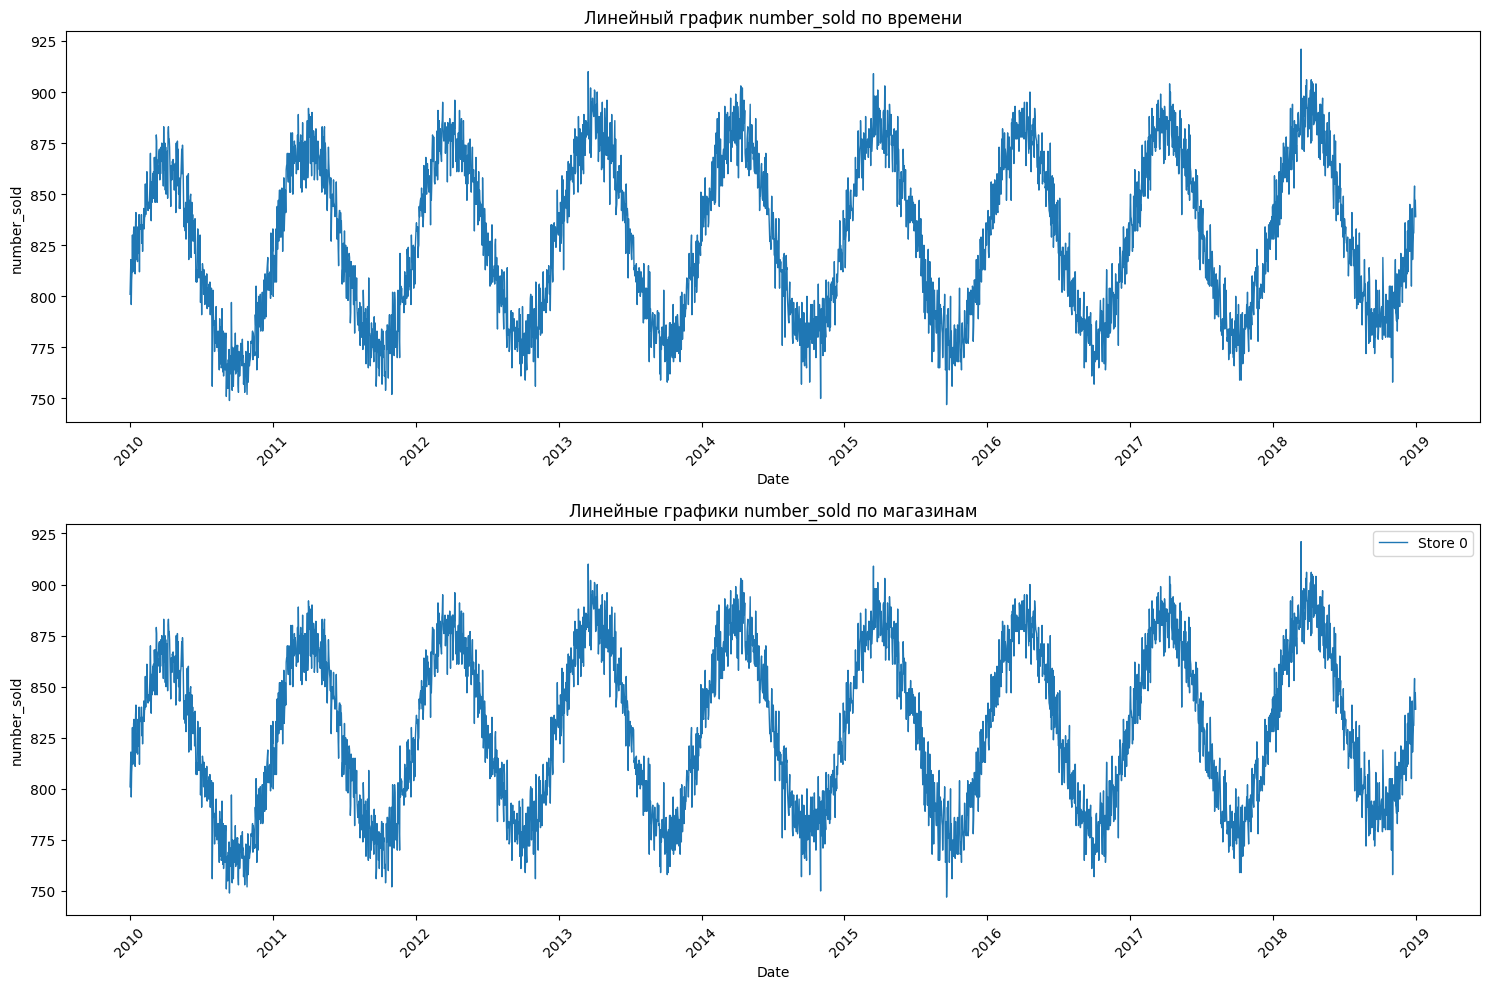

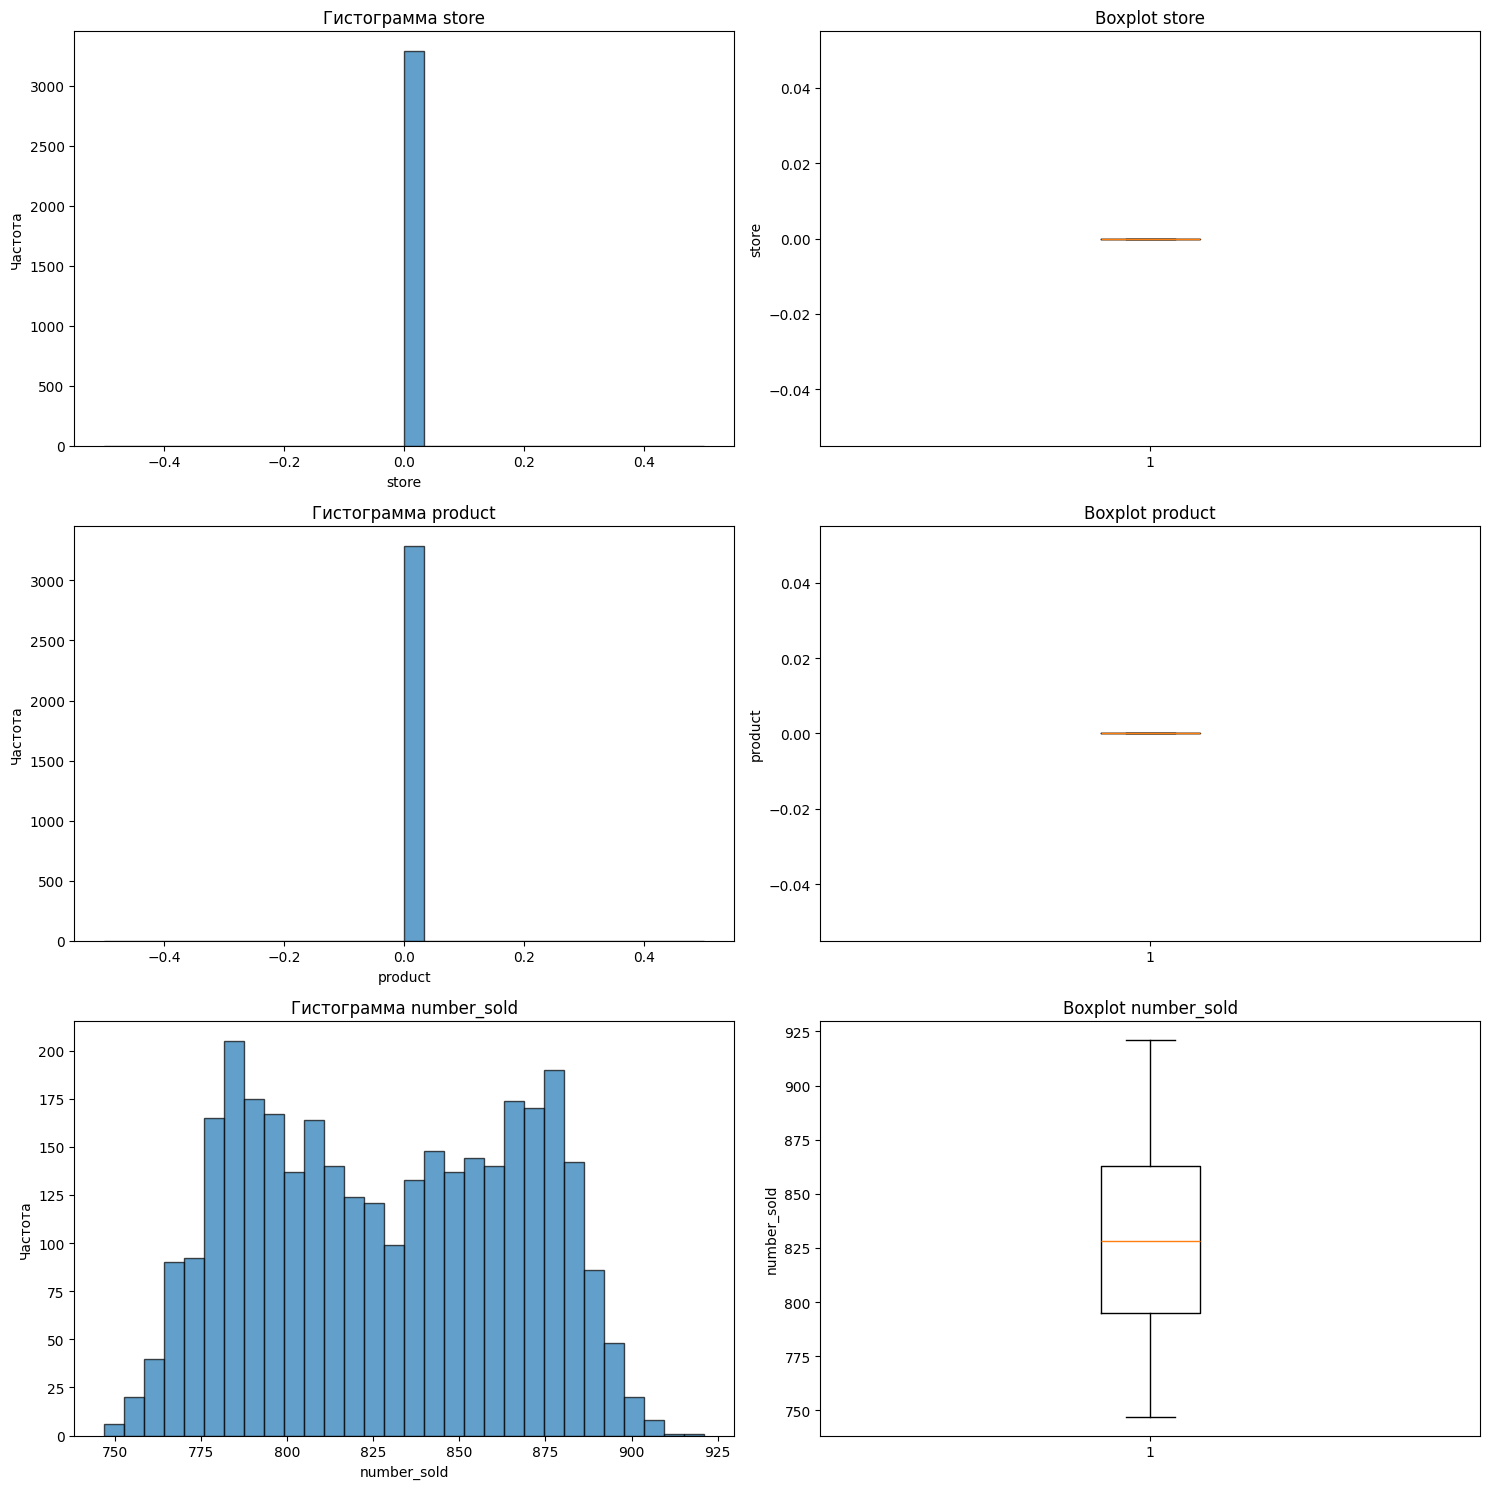

Сильные корреляции (Pearson > 0.8):

Сильные корреляции (Spearman > 0.8):


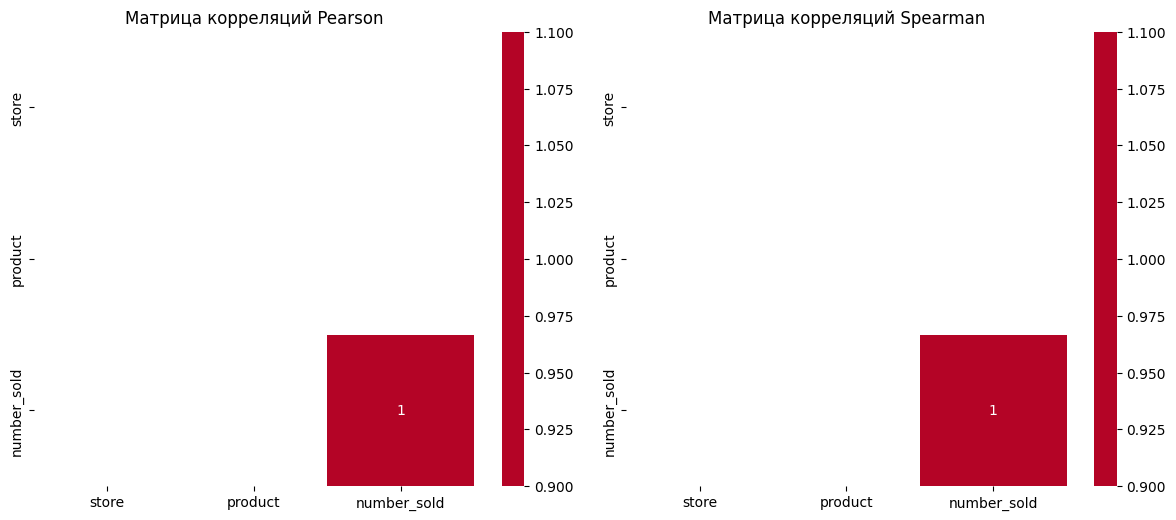

In [3]:
def load_data(file_path):
    return pd.read_csv(file_path)

def descriptive_statistical_analysis(df):
    df_analysis = df.copy()
    calculate_descriptive_stats(df_analysis)
    create_time_plots(df_analysis)
    create_distribution_plots(df_analysis)
    create_correlation_analysis(df_analysis)
    return df_analysis

def calculate_descriptive_stats(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    stats_df = df[numeric_columns].describe()
    stats_df.loc['skewness'] = df[numeric_columns].skew()
    stats_df.loc['kurtosis'] = df[numeric_columns].kurtosis()
    print(stats_df)

def create_time_plots(df):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['number_sold'], linewidth=1)
    plt.title('Линейный график number_sold по времени')
    plt.xlabel('Date')
    plt.ylabel('number_sold')
    plt.xticks(rotation=45)
    
    if 'store' in df.columns:
        plt.subplot(2, 1, 2)
        for store in df['store'].unique():
            store_data = df[df['store'] == store]
            plt.plot(store_data['Date'], store_data['number_sold'], label=f'Store {store}', linewidth=1)
        plt.title('Линейные графики number_sold по магазинам')
        plt.xlabel('Date')
        plt.ylabel('number_sold')
        plt.legend()
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def create_distribution_plots(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    n_plots = len(numeric_columns)
    
    fig, axes = plt.subplots(n_plots, 2, figsize=(15, 5 * n_plots))
    
    for i, col in enumerate(numeric_columns):
        axes[i, 0].hist(df[col], bins=30, alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'Гистограмма {col}')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Частота')
        
        axes[i, 1].boxplot(df[col])
        axes[i, 1].set_title(f'Boxplot {col}')
        axes[i, 1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

def create_correlation_analysis(df):
    numeric_df = df.select_dtypes(include=[np.number])
    
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    corr_pearson = numeric_df.corr(method='pearson')
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций Pearson')
    
    plt.subplot(2, 2, 2)
    corr_spearman = numeric_df.corr(method='spearman')
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций Spearman')
    
    high_corr_pearson = (corr_pearson.abs() > 0.8) & (corr_pearson.abs() < 1.0)
    high_corr_spearman = (corr_spearman.abs() > 0.8) & (corr_spearman.abs() < 1.0)
    
    print("Сильные корреляции (Pearson > 0.8):")
    for i in range(len(corr_pearson.columns)):
        for j in range(i+1, len(corr_pearson.columns)):
            if high_corr_pearson.iloc[i, j]:
                print(f"{corr_pearson.columns[i]} - {corr_pearson.columns[j]}: {corr_pearson.iloc[i, j]:.3f}")
    
    print("\nСильные корреляции (Spearman > 0.8):")
    for i in range(len(corr_spearman.columns)):
        for j in range(i+1, len(corr_spearman.columns)):
            if high_corr_spearman.iloc[i, j]:
                print(f"{corr_spearman.columns[i]} - {corr_spearman.columns[j]}: {corr_spearman.iloc[i, j]:.3f}")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    df = load_data('cleaned_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df_analyzed = descriptive_statistical_analysis(df)

#### Проверка на стационарность

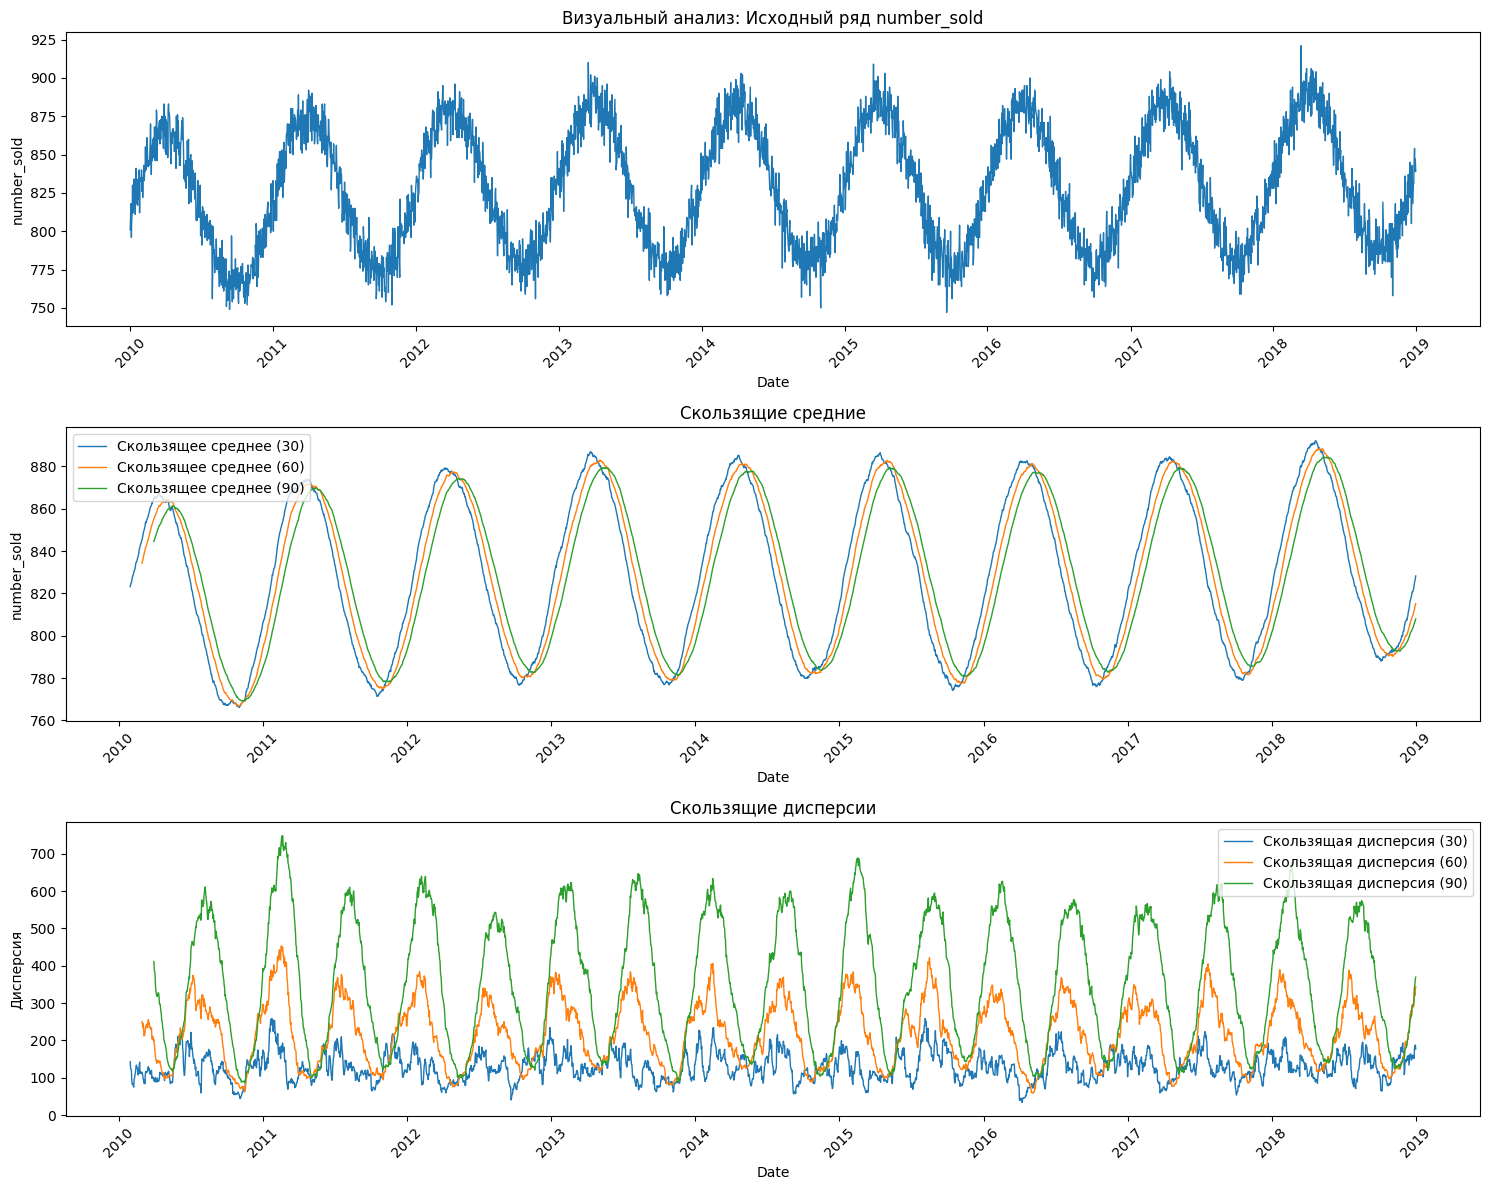


Окно 30:
Скользящее среднее - станд. отклонение: 36.898
Скользящая дисперсия - станд. отклонение: 36.906

Окно 60:
Скользящее среднее - станд. отклонение: 35.826
Скользящая дисперсия - станд. отклонение: 86.037

Окно 90:
Скользящее среднее - станд. отклонение: 33.981
Скользящая дисперсия - станд. отклонение: 170.228

СТАТИСТИЧЕСКИЕ ТЕСТЫ НА СТАЦИОНАРНОСТЬ

Тест Дики-Фуллера (ADF):
ADF Statistic: -5.051465
p-value: 0.000018
Критические значения:
  1%: -3.432359
  5%: -2.862428
  10%: -2.567243

Тест KPSS:
KPSS Statistic: 0.074052
p-value: 0.100000
Критические значения:
  10%: 0.347000
  5%: 0.463000
  2.5%: 0.574000
  1%: 0.739000

Интерпретация:
ADF: p-value < 0.05 → ряд стационарен
KPSS: p-value > 0.05 → ряд стационарен

Ряд стационарен. Дополнительные преобразования не требуются.


C:\Users\DmitrievMS\AppData\Local\Temp\ipykernel_18536\1784585300.py:61: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series)


In [5]:
def load_data(file_path):
    return pd.read_csv(file_path)

def stationarity_analysis(df):
    df_analysis = df.copy()
    visual_stationarity_check(df_analysis)
    calculate_rolling_stats(df_analysis)
    perform_statistical_tests(df_analysis)
    return df_analysis

def visual_stationarity_check(df):
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 1, 1)
    plt.plot(df['Date'], df['number_sold'], linewidth=1)
    plt.title('Визуальный анализ: Исходный ряд number_sold')
    plt.xlabel('Date')
    plt.ylabel('number_sold')
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 2)
    plt.plot(df['Date'], df['number_sold'].rolling(window=30).mean(), label='Скользящее среднее (30)', linewidth=1)
    plt.plot(df['Date'], df['number_sold'].rolling(window=60).mean(), label='Скользящее среднее (60)', linewidth=1)
    plt.plot(df['Date'], df['number_sold'].rolling(window=90).mean(), label='Скользящее среднее (90)', linewidth=1)
    plt.title('Скользящие средние')
    plt.xlabel('Date')
    plt.ylabel('number_sold')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.subplot(3, 1, 3)
    plt.plot(df['Date'], df['number_sold'].rolling(window=30).var(), label='Скользящая дисперсия (30)', linewidth=1)
    plt.plot(df['Date'], df['number_sold'].rolling(window=60).var(), label='Скользящая дисперсия (60)', linewidth=1)
    plt.plot(df['Date'], df['number_sold'].rolling(window=90).var(), label='Скользящая дисперсия (90)', linewidth=1)
    plt.title('Скользящие дисперсии')
    plt.xlabel('Date')
    plt.ylabel('Дисперсия')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def calculate_rolling_stats(df):
    windows = [30, 60, 90]
    for window in windows:
        rolling_mean = df['number_sold'].rolling(window=window).mean()
        rolling_var = df['number_sold'].rolling(window=window).var()
        print(f"\nОкно {window}:")
        print(f"Скользящее среднее - станд. отклонение: {rolling_mean.std():.3f}")
        print(f"Скользящая дисперсия - станд. отклонение: {rolling_var.std():.3f}")

def perform_statistical_tests(df):
    series = df['number_sold'].dropna()
    
    print("\n" + "="*50)
    print("СТАТИСТИЧЕСКИЕ ТЕСТЫ НА СТАЦИОНАРНОСТЬ")
    print("="*50)
    
    adf_result = adfuller(series)
    kpss_result = kpss(series)
    
    print(f"\nТест Дики-Фуллера (ADF):")
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print(f"Критические значения:")
    for key, value in adf_result[4].items():
        print(f"  {key}: {value:.6f}")
    
    print(f"\nТест KPSS:")
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print(f"Критические значения:")
    for key, value in kpss_result[3].items():
        print(f"  {key}: {value:.6f}")
    
    is_stationary_adf = adf_result[1] < 0.05
    is_stationary_kpss = kpss_result[1] > 0.05
    
    print(f"\nИнтерпретация:")
    print(f"ADF: p-value {'<' if is_stationary_adf else '>'} 0.05 → ряд {'стационарен' if is_stationary_adf else 'нестационарен'}")
    print(f"KPSS: p-value {'>' if is_stationary_kpss else '<'} 0.05 → ряд {'стационарен' if is_stationary_kpss else 'нестационарен'}")
    
    if not (is_stationary_adf and is_stationary_kpss):
        print(f"\nРяд нестационарен. Применяем дифференцирование 1-го порядка...")
        apply_differentiation(df, series)
    else:
        print(f"\nРяд стационарен. Дополнительные преобразования не требуются.")

def apply_differentiation(df, original_series):
    differentiated = original_series.diff().dropna()
    df_diff = df.iloc[1:].copy()
    df_diff['number_sold_diff'] = differentiated
    
    print(f"\nПосле дифференцирования 1-го порядка:")
    
    adf_result_diff = adfuller(differentiated)
    kpss_result_diff = kpss(differentiated)
    
    print(f"ADF p-value: {adf_result_diff[1]:.6f} → {'стационарен' if adf_result_diff[1] < 0.05 else 'нестационарен'}")
    print(f"KPSS p-value: {kpss_result_diff[1]:.6f} → {'стационарен' if kpss_result_diff[1] > 0.05 else 'нестационарен'}")
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], original_series, linewidth=1)
    plt.title('Исходный ряд')
    plt.xlabel('Date')
    plt.ylabel('number_sold')
    plt.xticks(rotation=45)
    
    plt.subplot(2, 1, 2)
    plt.plot(df_diff['Date'], differentiated, linewidth=1, color='orange')
    plt.title('Ряд после дифференцирования 1-го порядка')
    plt.xlabel('Date')
    plt.ylabel('number_sold (разности)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return df_diff

if __name__ == "__main__":
    df = load_data('cleaned_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df_stationarity = stationarity_analysis(df)

#### Лаги

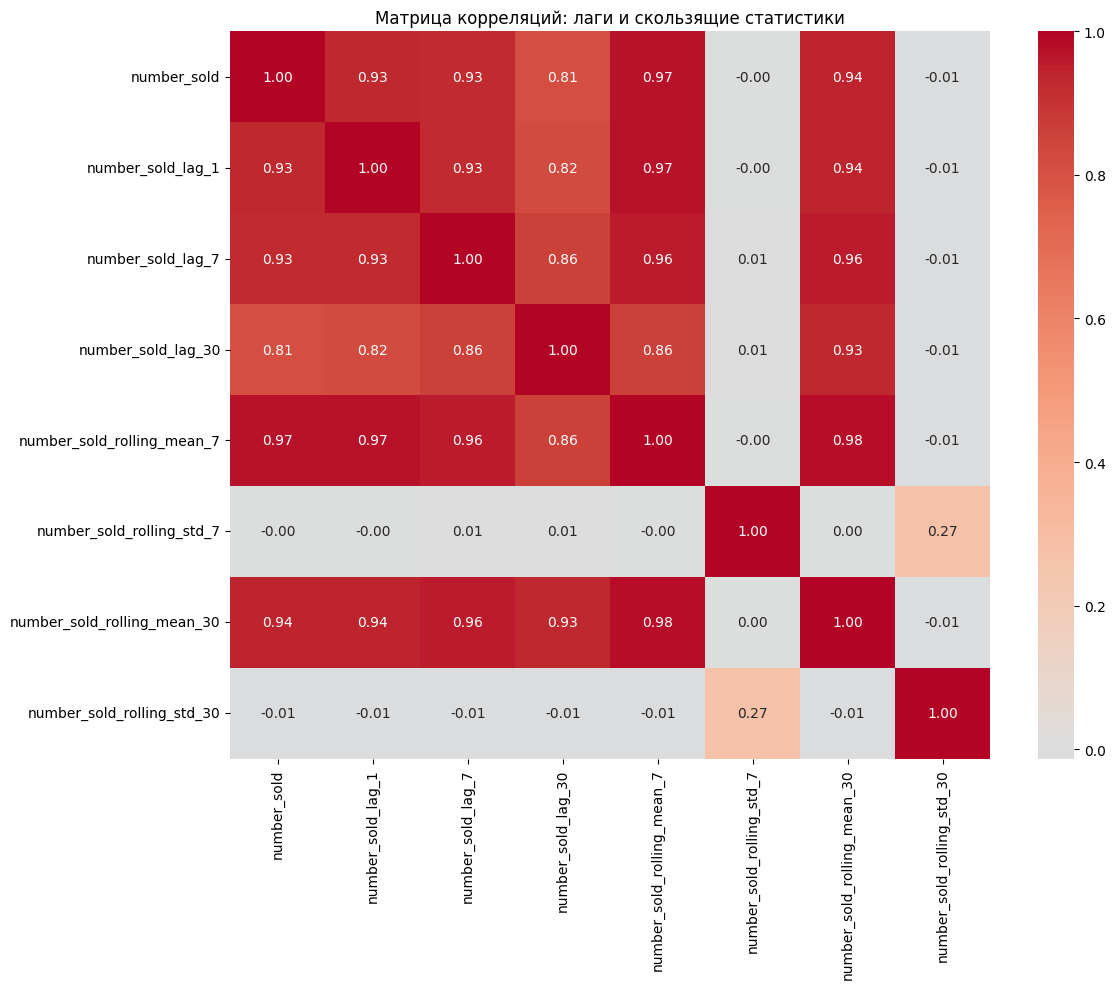

Корреляции с целевой переменной (number_sold):
number_sold_rolling_mean_7: 0.970
number_sold_rolling_mean_30: 0.938
number_sold_lag_1: 0.933
number_sold_lag_7: 0.926
number_sold_lag_30: 0.815
number_sold_rolling_std_7: -0.003
number_sold_rolling_std_30: -0.008

Проверка мультиколлинеарности (VIF):
                       feature           VIF
5  number_sold_rolling_mean_30  39980.646722
3   number_sold_rolling_mean_7  29349.026150
0            number_sold_lag_1   8226.703818
1            number_sold_lag_7   6843.890367
2           number_sold_lag_30   5862.845328
6   number_sold_rolling_std_30     48.241740
4    number_sold_rolling_std_7     13.448856

Предупреждение: Высокий VIF (>10) у признаков:
  number_sold_lag_1: VIF = 8226.70
  number_sold_lag_7: VIF = 6843.89
  number_sold_lag_30: VIF = 5862.85
  number_sold_rolling_mean_7: VIF = 29349.03
  number_sold_rolling_std_7: VIF = 13.45
  number_sold_rolling_mean_30: VIF = 39980.65
  number_sold_rolling_std_30: VIF = 48.24


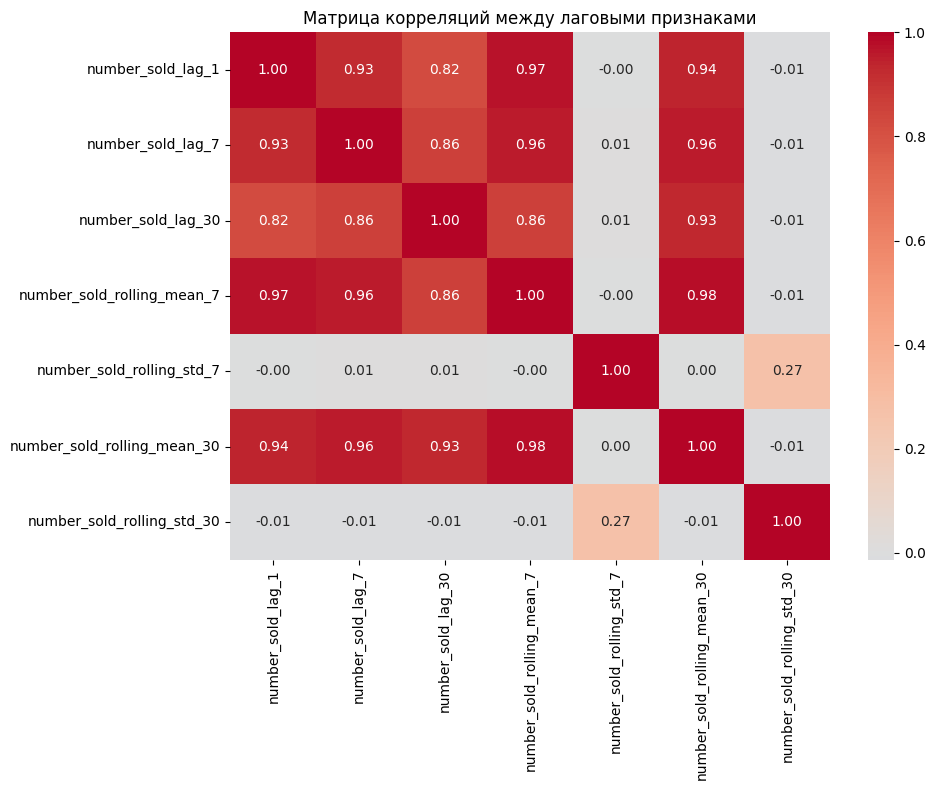

In [7]:
def load_data(file_path):
    return pd.read_csv(file_path)

def create_lag_features(df):
    df_lags = df.copy()
    df_lags = create_target_lags(df_lags)
    df_lags = create_rolling_statistics(df_lags)
    df_lags = analyze_lag_correlations(df_lags)
    check_multicollinearity(df_lags)
    return df_lags

def create_target_lags(df):
    lags = [1, 7, 30]
    for lag in lags:
        df[f'number_sold_lag_{lag}'] = df['number_sold'].shift(lag)
    
    if 'store' in df.columns and 'product' in df.columns:
        df = df.sort_values(['store', 'product', 'Date']).reset_index(drop=True)
        for lag in lags:
            df[f'number_sold_lag_{lag}'] = df.groupby(['store', 'product'])['number_sold'].shift(lag)
    
    return df

def create_rolling_statistics(df):
    windows = [7, 30]
    
    for window in windows:
        df[f'number_sold_rolling_mean_{window}'] = df['number_sold'].rolling(window=window).mean()
        df[f'number_sold_rolling_std_{window}'] = df['number_sold'].rolling(window=window).std()
    
    if 'store' in df.columns and 'product' in df.columns:
        for window in windows:
            df[f'number_sold_rolling_mean_{window}'] = df.groupby(['store', 'product'])['number_sold'].transform(
                lambda x: x.rolling(window=window).mean())
            df[f'number_sold_rolling_std_{window}'] = df.groupby(['store', 'product'])['number_sold'].transform(
                lambda x: x.rolling(window=window).std())
    
    return df

def analyze_lag_correlations(df):
    lag_columns = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    numeric_columns = ['number_sold'] + lag_columns
    
    correlation_matrix = df[numeric_columns].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Матрица корреляций: лаги и скользящие статистики')
    plt.tight_layout()
    plt.show()
    
    target_correlations = correlation_matrix['number_sold'].drop('number_sold').sort_values(ascending=False)
    
    print("Корреляции с целевой переменной (number_sold):")
    for feature, corr in target_correlations.items():
        print(f"{feature}: {corr:.3f}")
    
    return df

def check_multicollinearity(df):
    lag_columns = [col for col in df.columns if 'lag' in col or 'rolling' in col]
    
    if not lag_columns:
        return df
    
    X = df[lag_columns].dropna()
    
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    print("\nПроверка мультиколлинеарности (VIF):")
    print(vif_data.sort_values("VIF", ascending=False))
    
    high_vif = vif_data[vif_data["VIF"] > 10]
    if not high_vif.empty:
        print(f"\nПредупреждение: Высокий VIF (>10) у признаков:")
        for _, row in high_vif.iterrows():
            print(f"  {row['feature']}: VIF = {row['VIF']:.2f}")
    
    correlation_matrix_lags = X.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_lags, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Матрица корреляций между лаговыми признаками')
    plt.tight_layout()
    plt.show()
    
    return df

if __name__ == "__main__":
    df = load_data('cleaned_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df_lags = create_lag_features(df)
    df_lags.to_csv('data_with_lags.csv', index=False)

#### Анализ автокорреляций

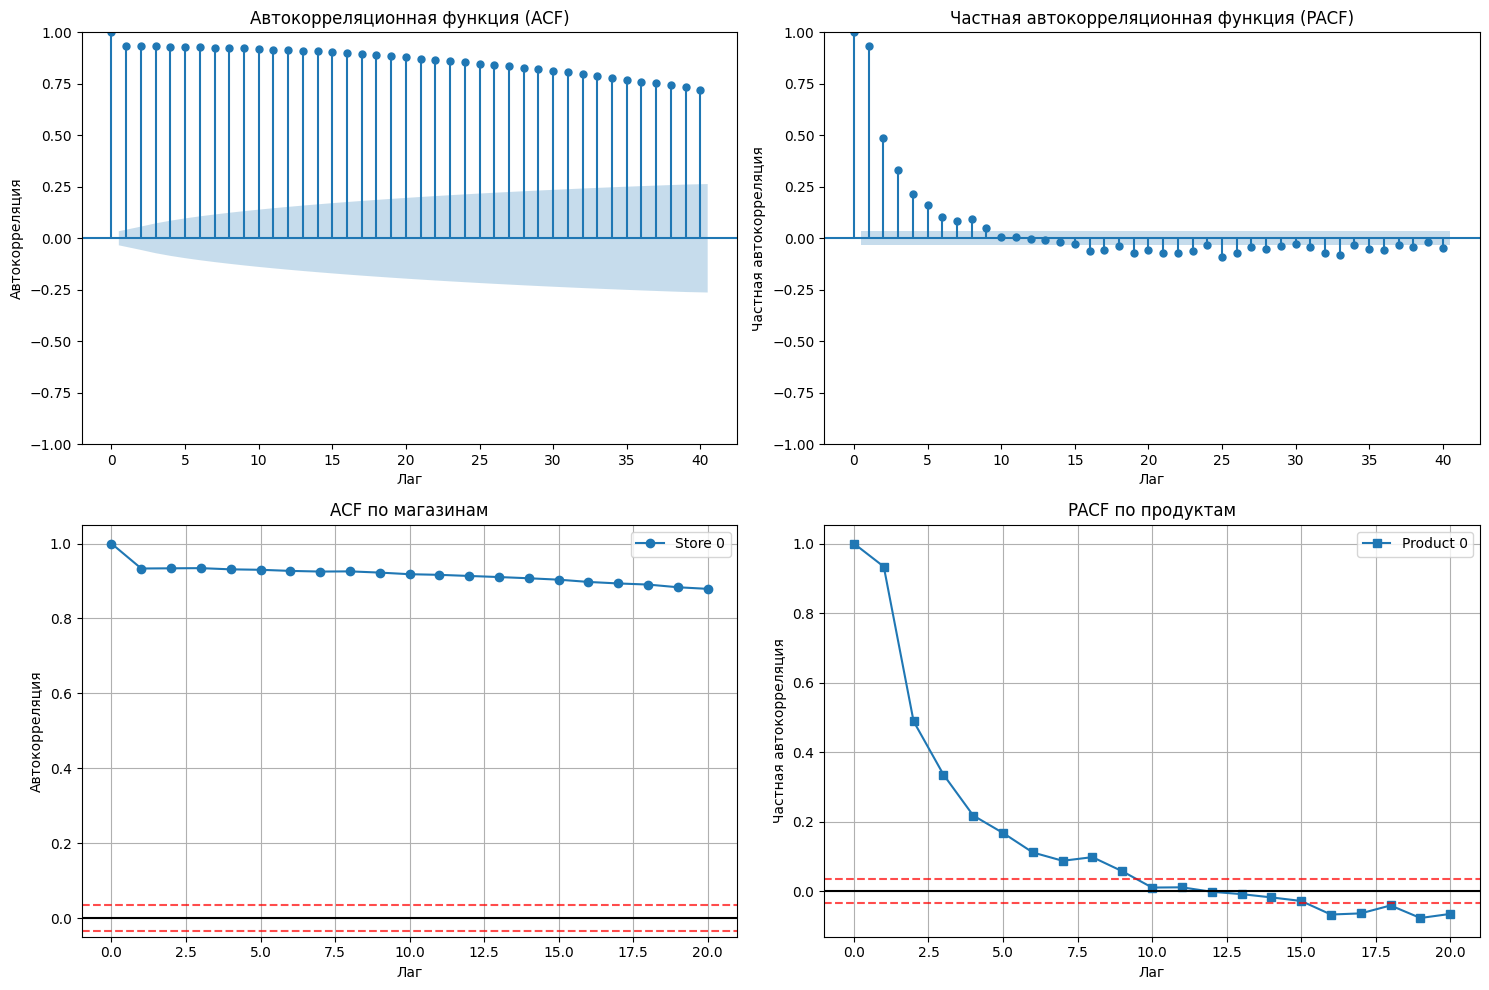

СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ЛАГИ

Значимые лаги ACF (выходят за доверительный интервал):
Нет значимых лагов в ACF

Значимые лаги PACF (выходящие за доверительный интервал):
Лаг 10: 0.011
Лаг 11: 0.012
Лаг 12: -0.001
Лаг 13: -0.008
Лаг 14: -0.017
Лаг 15: -0.028
Лаг 16: -0.066
Лаг 17: -0.063
Лаг 18: -0.040
Лаг 19: -0.077

ИНТЕРПРЕТАЦИЯ:
Резкий обрыв в PACF на лаге 10 → возможный порядок AR(10)
ACF: Быстрое затухание → MA-компонент может быть слабым


In [10]:
def load_data(file_path):
    return pd.read_csv(file_path)

def autocorrelation_analysis(df):
    df_acf = df.copy()
    create_acf_plots(df_acf)
    analyze_significant_lags(df_acf)
    return df_acf

def create_acf_plots(df):
    series = df['number_sold'].dropna()
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plot_acf(series, lags=40, ax=plt.gca(), alpha=0.05)
    plt.title('Автокорреляционная функция (ACF)')
    plt.xlabel('Лаг')
    plt.ylabel('Автокорреляция')
    
    plt.subplot(2, 2, 2)
    plot_pacf(series, lags=40, ax=plt.gca(), alpha=0.05)
    plt.title('Частная автокорреляционная функция (PACF)')
    plt.xlabel('Лаг')
    plt.ylabel('Частная автокорреляция')
    
    if 'store' in df.columns:
        plt.subplot(2, 2, 3)
        for store in df['store'].unique()[:3]:
            store_series = df[df['store'] == store]['number_sold'].dropna()
            acf_values = acf(store_series, nlags=20)
            plt.plot(range(21), acf_values, label=f'Store {store}', marker='o')
        plt.axhline(y=0, color='black', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.7)
        plt.axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.7)
        plt.title('ACF по магазинам')
        plt.xlabel('Лаг')
        plt.ylabel('Автокорреляция')
        plt.legend()
        plt.grid(True)
    
    if 'product' in df.columns:
        plt.subplot(2, 2, 4)
        for product in df['product'].unique()[:3]:
            product_series = df[df['product'] == product]['number_sold'].dropna()
            pacf_values = pacf(product_series, nlags=20)
            plt.plot(range(21), pacf_values, label=f'Product {product}', marker='s')
        plt.axhline(y=0, color='black', linestyle='-')
        plt.axhline(y=1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.7)
        plt.axhline(y=-1.96/np.sqrt(len(series)), color='red', linestyle='--', alpha=0.7)
        plt.title('PACF по продуктам')
        plt.xlabel('Лаг')
        plt.ylabel('Частная автокорреляция')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def analyze_significant_lags(df):
    series = df['number_sold'].dropna()
    
    acf_values, acf_confint = acf(series, nlags=40, alpha=0.05)
    pacf_values, pacf_confint = pacf(series, nlags=40, alpha=0.05)
    
    acf_lower_bound = acf_confint[:, 0]
    acf_upper_bound = acf_confint[:, 1]
    pacf_lower_bound = pacf_confint[:, 0]
    pacf_upper_bound = pacf_confint[:, 1]
    
    significant_acf_lags = []
    significant_pacf_lags = []
    
    for lag in range(1, len(acf_values)):
        if abs(acf_values[lag]) > abs(acf_upper_bound[lag]) or abs(acf_values[lag]) < abs(acf_lower_bound[lag]):
            significant_acf_lags.append((lag, acf_values[lag]))
    
    for lag in range(1, len(pacf_values)):
        if abs(pacf_values[lag]) > abs(pacf_upper_bound[lag]) or abs(pacf_values[lag]) < abs(pacf_lower_bound[lag]):
            significant_pacf_lags.append((lag, pacf_values[lag]))
    
    print("СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ЛАГИ")
    print("=" * 50)
    
    print("\nЗначимые лаги ACF (выходят за доверительный интервал):")
    if significant_acf_lags:
        for lag, value in significant_acf_lags[:10]:
            print(f"Лаг {lag}: {value:.3f}")
    else:
        print("Нет значимых лагов в ACF")
    
    print("\nЗначимые лаги PACF (выходящие за доверительный интервал):")
    if significant_pacf_lags:
        for lag, value in significant_pacf_lags[:10]:
            print(f"Лаг {lag}: {value:.3f}")
    else:
        print("Нет значимых лагов в PACF")
    
    print("\nИНТЕРПРЕТАЦИЯ:")
    print("=" * 50)
    
    if significant_pacf_lags:
        pacf_cutoff_lag = significant_pacf_lags[0][0]
        print(f"Резкий обрыв в PACF на лаге {pacf_cutoff_lag} → возможный порядок AR({pacf_cutoff_lag})")
    else:
        print("PACF: Нет четкого обрыва → AR-компонент может быть слабым")
    
    acf_decay_slow = len([lag for lag, val in significant_acf_lags if lag <= 5]) >= 3
    if acf_decay_slow and significant_acf_lags:
        print("ACF: Постепенное затухание → возможный MA-компонент")
    else:
        print("ACF: Быстрое затухание → MA-компонент может быть слабым")
    
    seasonal_lags = [lag for lag, val in significant_acf_lags if lag in [7, 14, 21, 28, 30]]
    if seasonal_lags:
        print(f"Сезонные паттерны обнаружены на лагах: {seasonal_lags}")

if __name__ == "__main__":
    df = load_data('data_with_lags.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df_acf = autocorrelation_analysis(df)

#### Декомпозиция ряда

Используемая частота для декомпозиции: 365


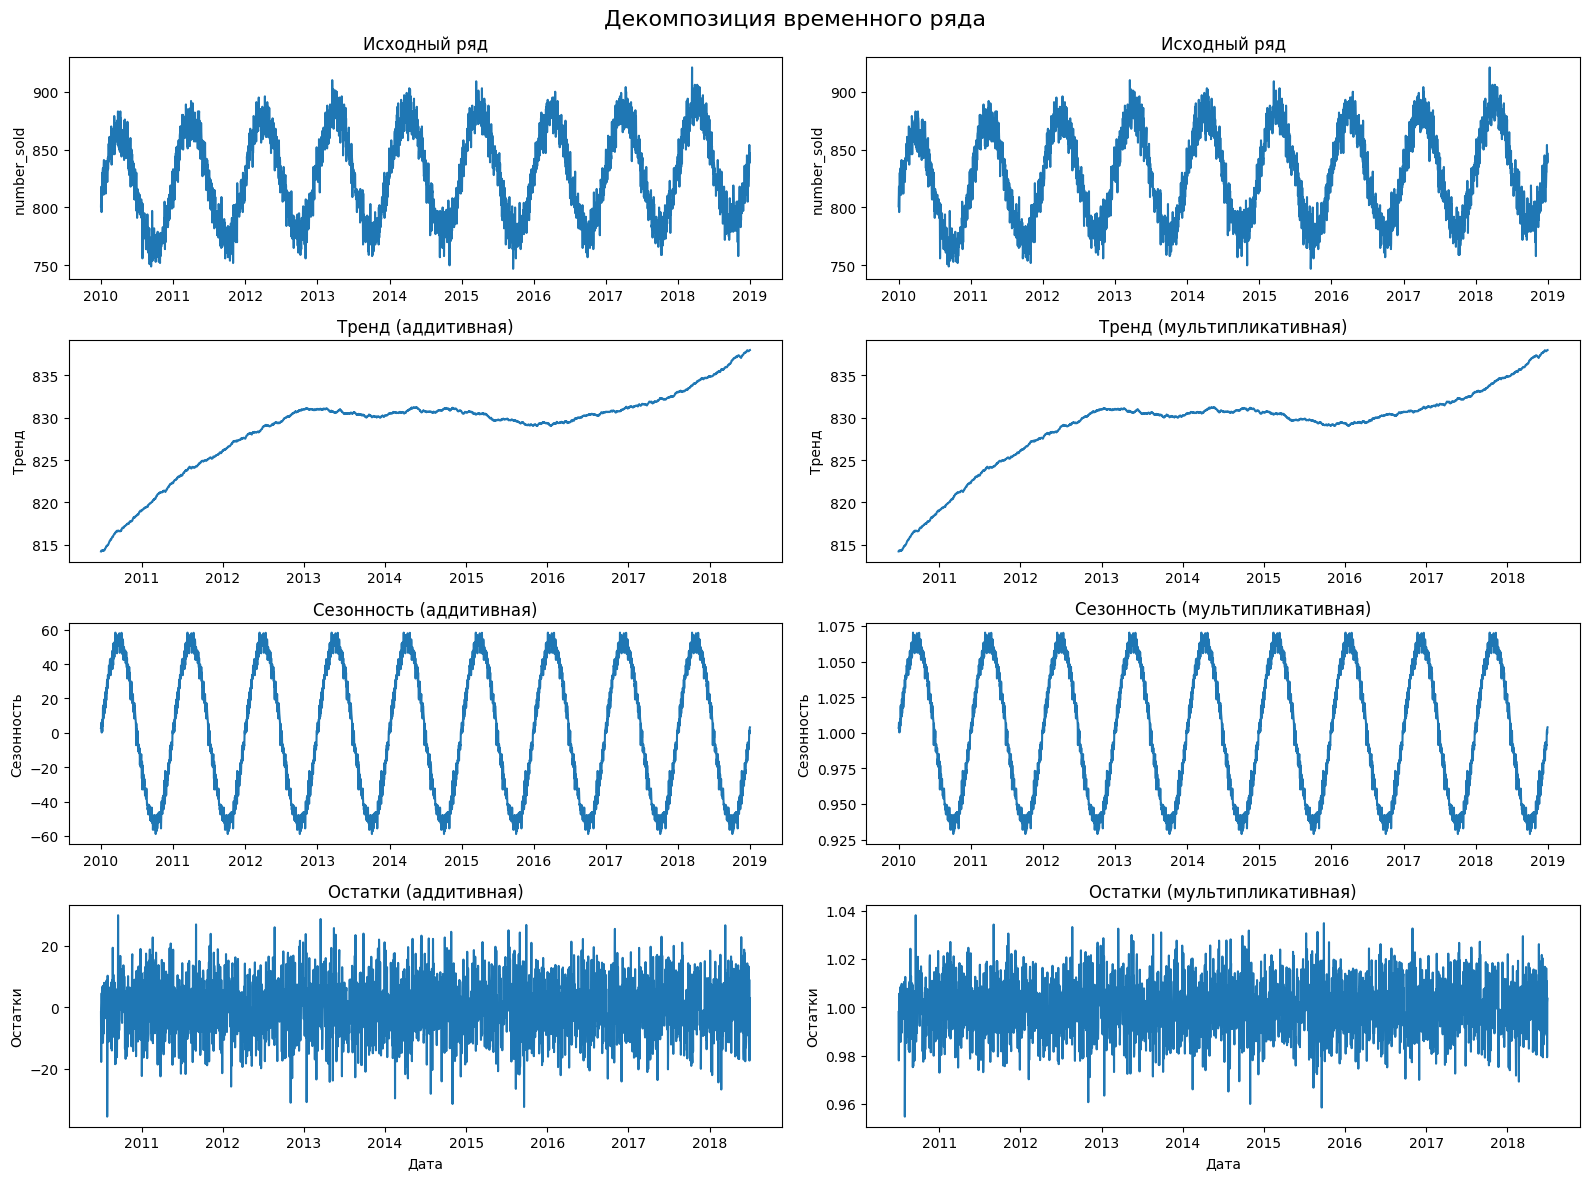

АНАЛИЗ КОМПОНЕНТ ДЕКОМПОЗИЦИИ

АДДИТИВНАЯ МОДЕЛЬ:
Сила тренда: Слабый
Сила сезонности: Сильная
Анализ остатков: Высокая волатильность

МУЛЬТИПЛИКАТИВНАЯ МОДЕЛЬ:
Сила тренда: Слабый
Сила сезонности: Умеренная
Анализ остатков: Систематические ошибки (неслучайные)

Амплитуда сезонности (аддитивная): 117.240
Амплитуда сезонности (мультипликативная): 0.141
Рекомендуется аддитивная модель (стабильная амплитуда сезонности)


In [12]:
def load_data(file_path):
    return pd.read_csv(file_path)

def time_series_decomposition(df):
    df_decomp = df.copy()
    perform_decomposition_analysis(df_decomp)
    return df_decomp

def perform_decomposition_analysis(df):
    df_sorted = df.sort_values('Date').set_index('Date')
    series = df_sorted['number_sold'].dropna()
    
    if len(series) < 2 * 7:
        print("Недостаточно данных для декомпозиции")
        return
    
    freq = determine_best_frequency(series)
    
    print(f"Используемая частота для декомпозиции: {freq}")
    
    try:
        additive_decomp = seasonal_decompose(series, model='additive', period=freq)
        multiplicative_decomp = seasonal_decompose(series, model='multiplicative', period=freq)
        
        plot_decomposition_results(additive_decomp, multiplicative_decomp, series)
        analyze_decomposition_components(additive_decomp, multiplicative_decomp)
        
    except Exception as e:
        print(f"Ошибка при декомпозиции: {e}")
        freq = len(series) // 2
        if freq >= 2:
            additive_decomp = seasonal_decompose(series, model='additive', period=freq)
            multiplicative_decomp = seasonal_decompose(series, model='multiplicative', period=freq)
            plot_decomposition_results(additive_decomp, multiplicative_decomp, series)
            analyze_decomposition_components(additive_decomp, multiplicative_decomp)

def determine_best_frequency(series):
    if len(series) >= 2 * 365:
        return 365
    elif len(series) >= 2 * 30:
        return 30
    elif len(series) >= 2 * 7:
        return 7
    else:
        return max(2, len(series) // 2)

def plot_decomposition_results(additive_decomp, multiplicative_decomp, series):
    fig, axes = plt.subplots(4, 2, figsize=(16, 12))
    fig.suptitle('Декомпозиция временного ряда', fontsize=16)
    
    axes[0, 0].plot(series)
    axes[0, 0].set_title('Исходный ряд')
    axes[0, 0].set_ylabel('number_sold')
    
    axes[0, 1].plot(series)
    axes[0, 1].set_title('Исходный ряд')
    axes[0, 1].set_ylabel('number_sold')
    
    axes[1, 0].plot(additive_decomp.trend)
    axes[1, 0].set_title('Тренд (аддитивная)')
    axes[1, 0].set_ylabel('Тренд')
    
    axes[1, 1].plot(multiplicative_decomp.trend)
    axes[1, 1].set_title('Тренд (мультипликативная)')
    axes[1, 1].set_ylabel('Тренд')
    
    axes[2, 0].plot(additive_decomp.seasonal)
    axes[2, 0].set_title('Сезонность (аддитивная)')
    axes[2, 0].set_ylabel('Сезонность')
    
    axes[2, 1].plot(multiplicative_decomp.seasonal)
    axes[2, 1].set_title('Сезонность (мультипликативная)')
    axes[2, 1].set_ylabel('Сезонность')
    
    axes[3, 0].plot(additive_decomp.resid)
    axes[3, 0].set_title('Остатки (аддитивная)')
    axes[3, 0].set_ylabel('Остатки')
    axes[3, 0].set_xlabel('Дата')
    
    axes[3, 1].plot(multiplicative_decomp.resid)
    axes[3, 1].set_title('Остатки (мультипликативная)')
    axes[3, 1].set_ylabel('Остатки')
    axes[3, 1].set_xlabel('Дата')
    
    plt.tight_layout()
    plt.show()

def analyze_decomposition_components(additive_decomp, multiplicative_decomp):
    print("АНАЛИЗ КОМПОНЕНТ ДЕКОМПОЗИЦИИ")
    print("=" * 50)
    
    trend_strength_additive = analyze_trend_strength(additive_decomp.trend)
    seasonality_strength_additive = analyze_seasonality_strength(additive_decomp.seasonal)
    residuals_analysis_additive = analyze_residuals(additive_decomp.resid)
    
    trend_strength_multiplicative = analyze_trend_strength(multiplicative_decomp.trend)
    seasonality_strength_multiplicative = analyze_seasonality_strength(multiplicative_decomp.seasonal)
    residuals_analysis_multiplicative = analyze_residuals(multiplicative_decomp.resid)
    
    print("\nАДДИТИВНАЯ МОДЕЛЬ:")
    print(f"Сила тренда: {trend_strength_additive}")
    print(f"Сила сезонности: {seasonality_strength_additive}")
    print(f"Анализ остатков: {residuals_analysis_additive}")
    
    print("\nМУЛЬТИПЛИКАТИВНАЯ МОДЕЛЬ:")
    print(f"Сила тренда: {trend_strength_multiplicative}")
    print(f"Сила сезонности: {seasonality_strength_multiplicative}")
    print(f"Анализ остатков: {residuals_analysis_multiplicative}")
    
    seasonal_amplitude_additive = additive_decomp.seasonal.max() - additive_decomp.seasonal.min()
    seasonal_amplitude_multiplicative = multiplicative_decomp.seasonal.max() - multiplicative_decomp.seasonal.min()
    
    print(f"\nАмплитуда сезонности (аддитивная): {seasonal_amplitude_additive:.3f}")
    print(f"Амплитуда сезонности (мультипликативная): {seasonal_amplitude_multiplicative:.3f}")
    
    if seasonal_amplitude_multiplicative > 1.1:
        print("Рекомендуется мультипликативная модель (растущая амплитуда сезонности)")
    else:
        print("Рекомендуется аддитивная модель (стабильная амплитуда сезонности)")

def analyze_trend_strength(trend_component):
    trend_clean = trend_component.dropna()
    if len(trend_clean) == 0:
        return "Слабый/отсутствует"
    
    trend_variation = trend_clean.std()
    if trend_variation > trend_clean.mean() * 0.1:
        return "Сильный"
    elif trend_variation > trend_clean.mean() * 0.05:
        return "Умеренный"
    else:
        return "Слабый"

def analyze_seasonality_strength(seasonal_component):
    seasonal_clean = seasonal_component.dropna()
    if len(seasonal_clean) == 0:
        return "Слабая/отсутствует"
    
    seasonal_amplitude = seasonal_clean.max() - seasonal_clean.min()
    if seasonal_amplitude > seasonal_clean.mean() * 0.2:
        return "Сильная"
    elif seasonal_amplitude > seasonal_clean.mean() * 0.1:
        return "Умеренная"
    else:
        return "Слабая"

def analyze_residuals(residual_component):
    residuals_clean = residual_component.dropna()
    if len(residuals_clean) == 0:
        return "Недостаточно данных"
    
    residual_std = residuals_clean.std()
    residual_mean = residuals_clean.mean()
    
    if abs(residual_mean) > residual_std * 0.1:
        return "Систематические ошибки (неслучайные)"
    elif residual_std > residuals_clean.abs().mean() * 0.5:
        return "Высокая волатильность"
    else:
        return "Случайные (хорошая декомпозиция)"

if __name__ == "__main__":
    df = load_data('data_with_lags.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df_decomp = time_series_decomposition(df)